In [1]:
import pickle
import os
import sys
import matplotlib.pyplot as plt
from math import floor
import scipy.ndimage as ndimage
import pandas as pd

sys.path.append('../utils')
sys.path.append('../visualization')

from utils import get_corr_table, get_weights

dataset_name = 'orl'

In [2]:
# Read the best parameters configuration for each of the dimensionality reduction techniques
reduced_X_best = pickle.load(open(os.path.dirname(os.getcwd()) + f'/data/{dataset_name}/reduced/reduced_X_best.pkl', 'rb'))
X_train = pickle.load(open(os.path.dirname(os.getcwd()) + f'/data/{dataset_name}/processed/X_train.pkl', 'rb'))

# Calculate the correlation with the original features
# Calculate variation of each component
weights = get_weights(reduced_X_best, n_components=150)

# Calculate correlation with original features
df_corrs, df_corrs_avg = get_corr_table(reduced_X_best, X_train, abs=False, weighted=True, weights=weights)
df_corrs_avg = df_corrs_avg.reset_index()

train = pickle.load(open(os.path.dirname(os.getcwd()) + '/data/orl/split/X_train.pkl', 'rb'))

### Scores

In [2]:
scores_df = pd.read_csv(os.path.dirname(os.getcwd()) + f'/results/scores/{dataset_name}_scores.csv', index_col=0)
scores_df.loc[scores_df.sort_values(
        'Score', ascending=False).groupby('Dim. Technique')['Score'].idxmax()].sort_values('Score', ascending=False)[['Dim. Technique', 'Dim. Params', 'Score', 'Dimensions', 'Model']]

Dim. Technique         Dim. Params  Score Dimensions Model
41            LLE      k=18-reg=0.001  1.000     150Dim   SGD
20            PCA                 NaN  0.950     300Dim   SVC
34            LOL                 NaN  0.450      50Dim   SGD
30          SLMVP  Radial-Gammas=0.01  0.050      50Dim   SGD
21           KPCA              Radial  0.025     300Dim   SVC

In [3]:
most_correlated_pixels = {}
for key in df_corrs_avg.keys()[1:]:
    most_correlated_pixels[key] = df_corrs_avg.sort_values(by=key, ascending=False)['index'].values

# Plots most correlated pixels as a scatter plot superimposed on the image
def plot_most_correlated_pixels(dim_technique, num_pixels):
    # Get the position of the most correlated pixels
    pixels_pos = [[floor(x/112), x % 112] for x in most_correlated_pixels[dim_technique][:num_pixels]]

    fig = plt.figure(figsize=(10, 80))

    # plot train data highlighting the most correlated pixels
    for person in range(train.shape[0])[:24]:
        plt.subplot(40, 6, person + 1)
        plt.imshow(train[person].reshape(112, 92), cmap='gray')
        for pixel in pixels_pos:
            plt.scatter(*pixel, color='red', s=10)
        plt.axis('off')

    fig.text(0.5, 1, dim_technique, ha='center', fontsize=20)

    plt.tight_layout()
    plt.show()

# Plots the heatmap of the correlation superimposed on the image
def plot_correlation_heatmap(dim_technique):

    fig = plt.figure(figsize=(13, 5))

    # plot train data highlighting the most correlated pixels
    for person in range(train.shape[0])[:12]:
        plt.subplot(2, 6, person + 1)
        plt.imshow(train[person].reshape(112, 92), cmap='gray')

        heatmap_image = ndimage.gaussian_filter(df_corrs_avg[dim_technique].values.reshape(112, 92),
                                                        sigma=(10, 10),
                                                        order=0)
        heatmap_image = df_corrs_avg[dim_technique].values.reshape(112, 92)
        plt.imshow(heatmap_image, cmap='bwr', alpha=0.4)
        plt.axis('off')


    fig.text(0.5, 0.90, dim_technique, ha='center', fontsize=20)

    # Add colorbar
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='bwr'), ax=fig.axes)
    cbar.set_label('Correlation')

    plt.show()

### Heatmap

The images show a heatmap superimposed on the first instances of the train set. The intensity of each pixel in the heatmap reflects its correlation with the data projected onto the reduced spaces obtained with each of the dimensionality reduction techniques.

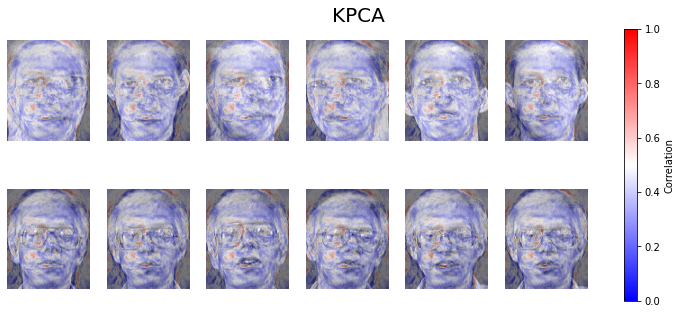

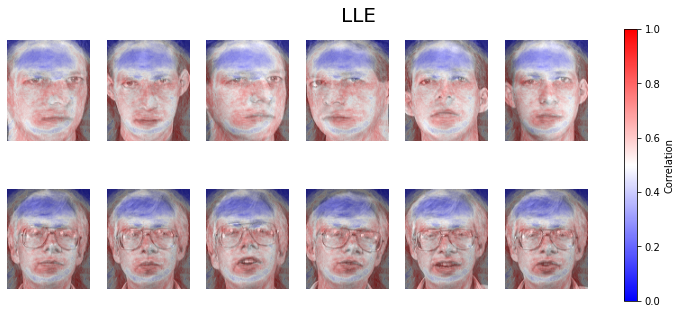

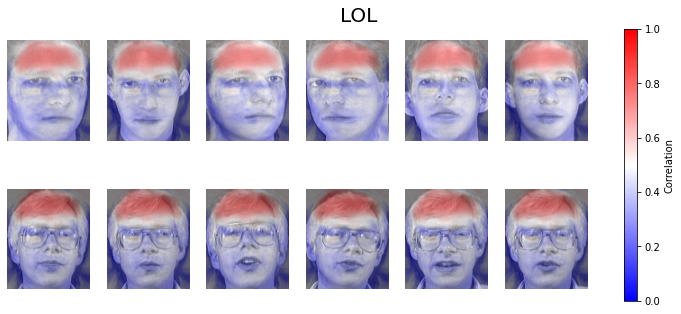

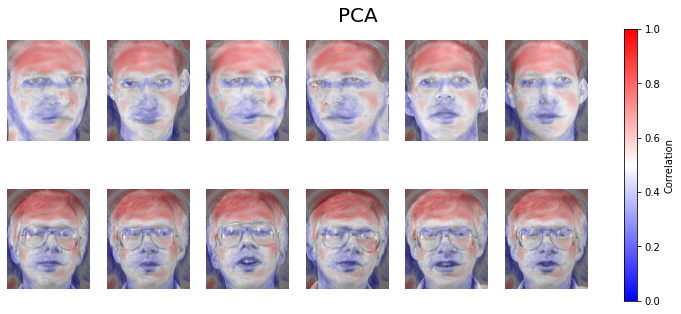

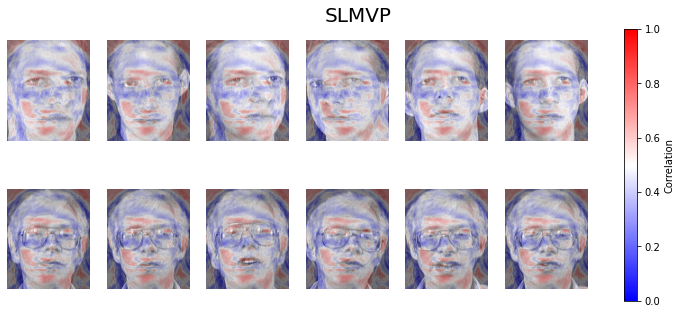

In [4]:
for dim_technique in df_corrs_avg.keys()[1:]:
    plot_correlation_heatmap(dim_technique)

### 100 Most Correlated Pixels

The 100 pixels that have the highest correlation with the data projected onto the reduced spaces are marked in red.

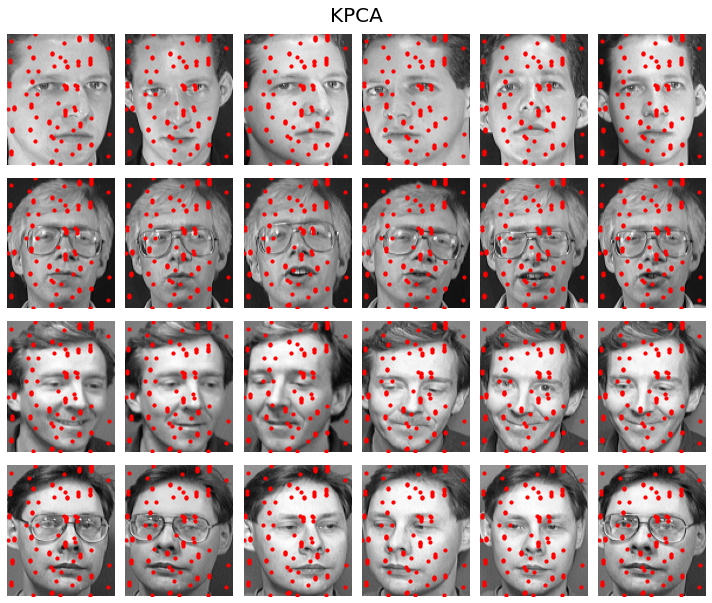

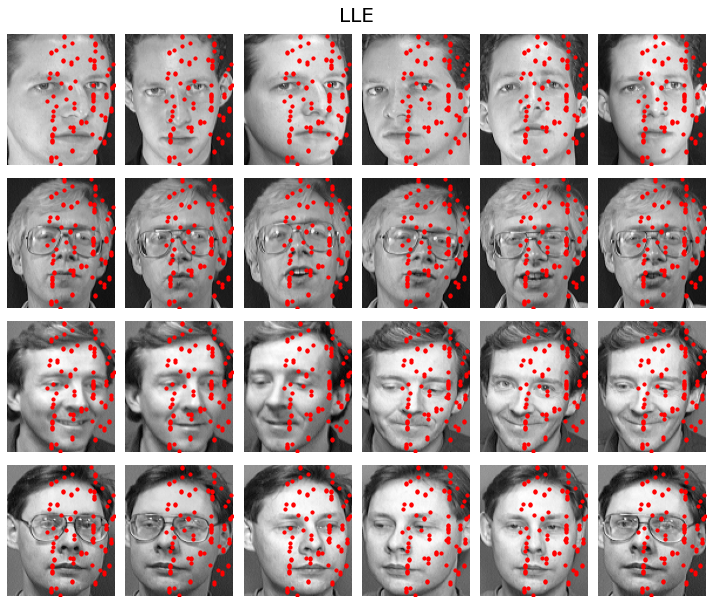

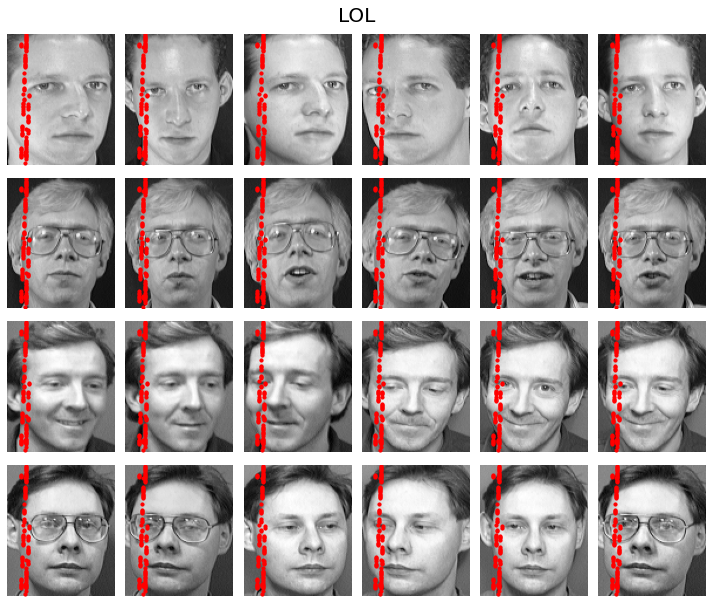

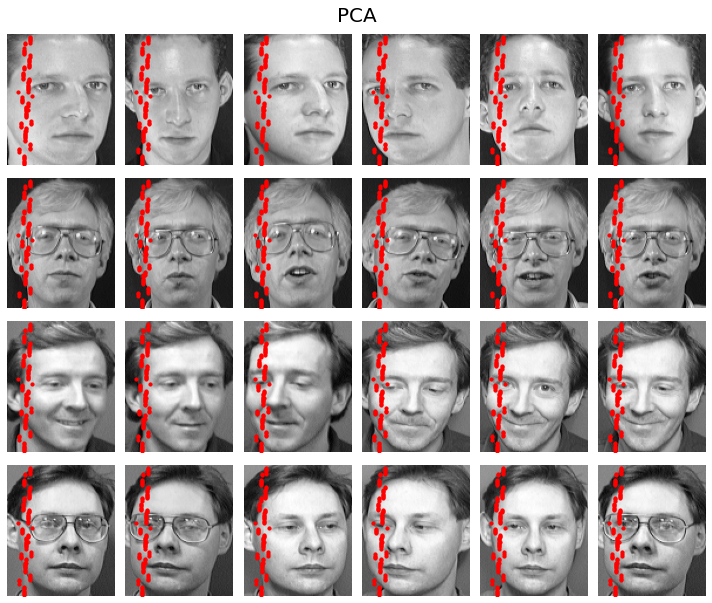

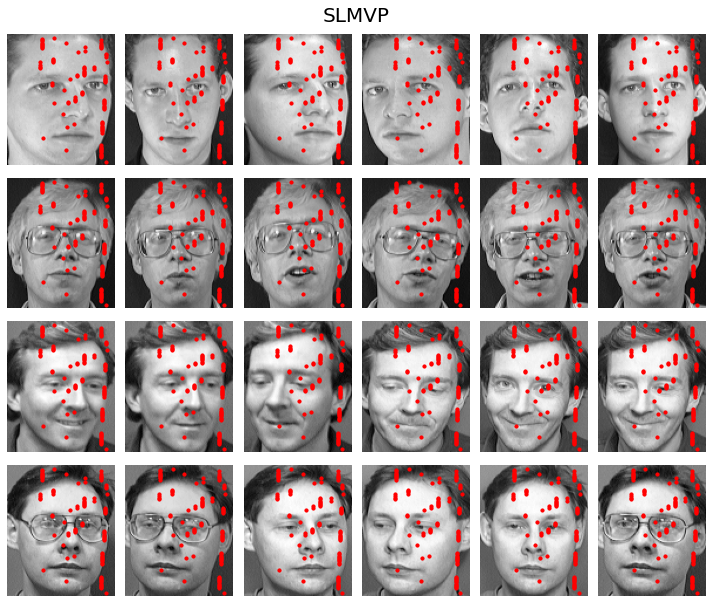

In [5]:
for dim_technique in df_corrs_avg.keys()[1:]:
    plot_most_correlated_pixels(dim_technique, num_pixels=100)